In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.signal as sg
import matplotlib.pyplot as plt
from matplotlib import patches
import pyarrow.dataset as ds
import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils
import os

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
# import zarr

# z = zarr.open('s3://aind-scratch-data/ben.hardcastle/cache/nwb_components/v0.0.184/spike_times.zarr')

# z['620263_2022-07-26_F-634'][:]

In [ ]:
# sel_unit="668755_2023-08-30_C-917"

# unit_df = ds.dataset(npc_lims.get_cache_path('units', version='0.0.184')).to_table(filter=(ds.field('unit_id') == sel_unit)).to_pandas()
# session_id=str(unit_df['subject_id'].values[0])+'_'+str(unit_df['date'].values[0])

# trials=pd.read_parquet(
#             npc_lims.get_cache_path('trials',session_id,version='0.0.184')
#         )

# time_before = 0.5
# time_after = 1.0
# binsize = 0.025
# trial_da = spike_utils.make_neuron_time_trials_tensor(unit_df, trials, time_before, time_after, binsize)

In [ ]:
# sel_unit="668755_2023-08-30_C-917"

# session_id=sel_unit[:17]

# units=pd.read_parquet(
#             npc_lims.get_cache_path('units',session_id)
#         )
# trials=pd.read_parquet(
#             npc_lims.get_cache_path('trials',session_id)
#         )

# unit_df=units.query('unit_id==@sel_unit')

# time_before = 0.5
# time_after = 1.0
# binsize = 0.025
# trial_da = spike_utils.make_neuron_time_trials_tensor(unit_df, trials, time_before, time_after, binsize)

In [2]:
def plot_unit_by_id(sel_unit,save_path=None,show_metric=None):

    unit_df = ds.dataset(npc_lims.get_cache_path('units', version='0.0.184')).to_table(filter=(ds.field('unit_id') == sel_unit)).to_pandas()
    session_id=str(unit_df['subject_id'].values[0])+'_'+str(unit_df['date'].values[0])

    trials=pd.read_parquet(
                npc_lims.get_cache_path('trials',session_id,version='0.0.184')
            )

    time_before = 0.5
    time_after = 1.0
    binsize = 0.025
    trial_da = spike_utils.make_neuron_time_trials_tensor(unit_df, trials, time_before, time_after, binsize)

    ##plot PSTH with context differences -- subplot for each stimulus
    fig,ax=plt.subplots(2,2,sharex=True,sharey=True)
    ax=ax.flatten()

    stims=['vis1','vis2','sound1','sound2']

    for st,stim in enumerate(stims):

        stim_trials=trials[:].query('stim_name==@stim')

        vis_context_spikes=trial_da.sel(
            trials=stim_trials.query('is_vis_context').index,
            unit_id=sel_unit,).mean(dim=['trials'])

        aud_context_spikes=trial_da.sel(
            trials=stim_trials.query('is_aud_context').index,
            unit_id=sel_unit,).mean(dim=['trials'])

        ax[st].plot(vis_context_spikes.time, vis_context_spikes.values, label='vis context',color='tab:green')
        ax[st].plot(aud_context_spikes.time, aud_context_spikes.values, label='aud context',color='tab:blue')
        ax[st].axvline(0, color='k', linestyle='--',alpha=0.5)
        ax[st].axvline(0.5, color='k', linestyle='--',alpha=0.5)
        ax[st].set_title(stim)
        ax[st].legend()
        ax[st].set_xlim([-0.5,1.0])

        if st>1:
            ax[st].set_xlabel('time (s)')
        if st==0 or st==2:
            ax[st].set_ylabel('spikes/s')

    if show_metric is not None:
        fig.suptitle('unit '+unit_df['unit_id'].values[0]+'; '+unit_df['structure'].values[0]+'; '+show_metric)
    else:
        fig.suptitle('unit '+unit_df['unit_id'].values[0]+'; '+unit_df['structure'].values[0])

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(os.path.join(save_path,unit_df['unit_id'].values[0]+'_context_modulation.png'),
                    dpi=300, facecolor='w', edgecolor='w',
                    orientation='portrait', format='png',
                    transparent=True, bbox_inches='tight', pad_inches=0.1,
                    metadata=None)
        plt.close()


    #plot lick vs. not lick
    fig,ax=plt.subplots(1,2,figsize=(6.4,3),sharex=True,sharey=True)
    ax=ax.flatten()
    stims=['vis1','sound1']
    for st,stim in enumerate(stims):
        
        if stim=='vis1':
            sel_context='aud'
        elif stim=='sound1':
            sel_context='vis'
        stim_trials=trials[:].query('stim_name==@stim and context_name==@sel_context')

        lick_spikes=trial_da.sel(
            trials=stim_trials.query('is_response').index,
            unit_id=sel_unit,).mean(dim=['trials'])

        non_lick_spikes=trial_da.sel(
            trials=stim_trials.query('not is_response').index,
            unit_id=sel_unit,).mean(dim=['trials'])

        ax[st].plot(lick_spikes.time, lick_spikes.values, label='licks',color='tab:red')
        ax[st].plot(non_lick_spikes.time, non_lick_spikes.values, label='non licks',color='tab:purple')
        ax[st].axvline(0, color='k', linestyle='--',alpha=0.5)
        ax[st].axvline(0.5, color='k', linestyle='--',alpha=0.5)
        ax[st].set_title(stim+'; '+sel_context+' context')
        ax[st].legend()
        ax[st].set_xlim([-0.5,1.0])

        if st>1:
            ax[st].set_xlabel('time (s)')
        if st==0 or st==2:
            ax[st].set_ylabel('spikes/s')

    if show_metric is not None:
        fig.suptitle('unit '+unit_df['unit_id'].values[0]+'; '+unit_df['structure'].values[0]+'; '+show_metric)
    else:
        fig.suptitle('unit '+unit_df['unit_id'].values[0]+'; '+unit_df['structure'].values[0])

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(os.path.join(save_path,unit_df['unit_id'].values[0]+'_lick_modulation.png'),
                    dpi=300, facecolor='w', edgecolor='w',
                    orientation='portrait', format='png',
                    transparent=True, bbox_inches='tight', pad_inches=0.1,
                    metadata=None)
        plt.close()



In [ ]:
filtered_units=pd.read_csv(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\single unit metrics\plots\filtered_units.csv")
filtered_units

In [ ]:
for u_idx,unit in filtered_units.iterrows():
    
    max_metric_pos=unit.iloc[3:].abs().argmax()
    metric_name=unit.iloc[3:].keys()[max_metric_pos]
    metric_val=unit.iloc[3:][max_metric_pos]
    metric_str=metric_name+'='+str(np.round(metric_val,decimals=2))

    plot_unit_by_id(unit['unit_id'],save_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\example PSTHs",show_metric=metric_str)

In [ ]:
unit=filtered_units.iloc[0]

In [ ]:
unit.keys()

In [ ]:
evoked_change_only=['644866_2023-02-08_F-70', '644866_2023-02-08_A-276',
                    '667252_2023-09-28_F-297', '667252_2023-09-28_F-95',
                    '667252_2023-09-28_F-88', '667252_2023-09-28_F-199',
                    '667252_2023-09-28_F-186', '667252_2023-09-28_A-20',
                    '668755_2023-08-30_B-131', '668755_2023-08-31_B-108',
                    '668755_2023-08-31_C-299', '674562_2023-10-02_E-189',
                    '674562_2023-10-03_E-8', '674562_2023-10-05_D-459',
                    '674562_2023-10-05_E-236', '681532_2023-10-16_F-274',
                    '681532_2023-10-16_D-295']

for iud in evoked_change_only:
    plot_unit_by_id(iud,save_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\evoked_change_only_PSTHs")

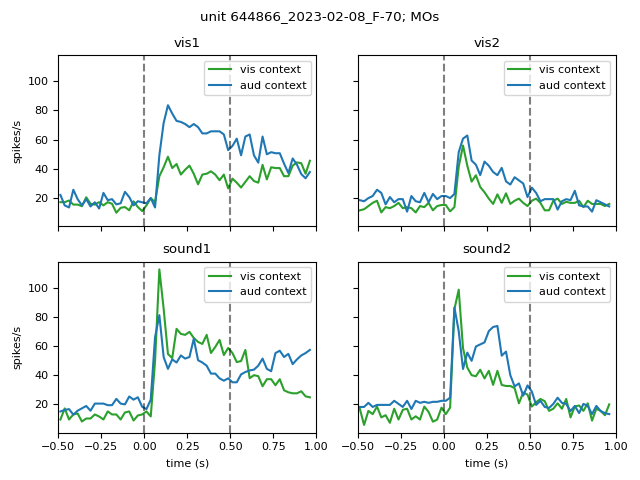

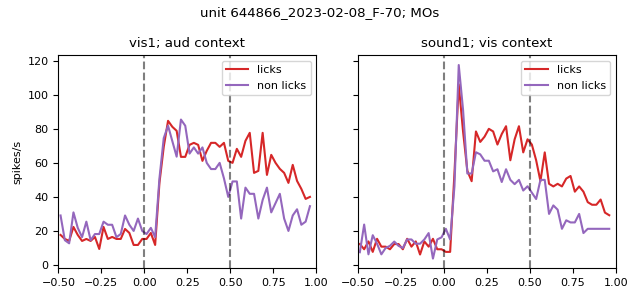

In [3]:
sel_unit='644866_2023-02-08_F-70'
# save_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\example PSTHs"
save_path=None
plot_unit_by_id(sel_unit,save_path)

In [ ]:
unit_df.columns

In [ ]:
time_before = 0.5
time_after = 1.0
binsize = 0.025
trial_da = spike_utils.make_neuron_time_trials_tensor(unit_df, trials, time_before, time_after, binsize)


In [ ]:
##plot PSTH with context differences -- subplot for each stimulus

fig,ax=plt.subplots(2,2,sharex=True,sharey=True)

ax=ax.flatten()

stims=['vis1','vis2','sound1','sound2']

for st,stim in enumerate(stims):

    stim_trials=trials[:].query('stim_name==@stim')

    vis_context_spikes=trial_da.sel(
        trials=stim_trials.query('is_vis_context').index,
        unit_id=sel_unit,).mean(dim=['trials'])

    aud_context_spikes=trial_da.sel(
        trials=stim_trials.query('is_aud_context').index,
        unit_id=sel_unit,).mean(dim=['trials'])

    ax[st].plot(vis_context_spikes.time, vis_context_spikes.values, label='vis context',color='g')
    ax[st].plot(aud_context_spikes.time, aud_context_spikes.values, label='aud context',color='b')
    ax[st].axvline(0, color='k', linestyle='--')
    ax[st].set_title(stim)
    ax[st].legend()
    ax[st].set_xlim([-0.25,0.5])

fig.suptitle('unit '+unit_df['unit_id'].values+'; '+unit_df['structure'].values)

fig.tight_layout()